In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import os
from pathlib import Path

os.chdir(path="/Research")
print(Path.cwd())
sys.path.append(os.path.abspath('/Research/gpudrive'))

from gpudrive.env.config import EnvConfig, SceneConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader

/Research


In [2]:

DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 2
DEVICE = "cuda:0"

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

In [3]:
# Make dataloader
data_loader = SceneDataLoader(
    root="gpudrive/data/processed/examples", # Path to the dataset
    batch_size=NUM_ENVS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=NUM_ENVS, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

print("Making the environment")

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device="cuda", 
    action_type="continuous" # "continuous" or "discrete"
)

Making the environment
Compiling GPU engine code:
/Research/gpudrive/external/madrona/src/mw/device/memory.cpp
/Research/gpudrive/external/madrona/src/mw/device/state.cpp
/Research/gpudrive/external/madrona/src/mw/device/crash.cpp
/Research/gpudrive/external/madrona/src/mw/device/consts.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/Research/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/Research/gpudrive/external/madrona/src/mw/device/host_print.cpp
/Research/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/Research/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/Research/gpudrive/external/madrona/src/mw/../core/base.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/tgs.c

/Research/gpudrive/src/level_gen.cpp(283): warning #177-D: function "madrona_gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





In [37]:
import importlib
import dev
import dev.waymo_iterator
importlib.reload(dev.waymo_iterator)
from dev.waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader

traj_data_loader = TrajectoryIterator(env, data_loader)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=NUM_ENVS))

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.categorical import Categorical

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.mean_head = nn.Linear(hidden_size, output_size)       # Output: 3 means (mu)
        self.log_std = nn.Parameter(torch.ones(output_size) * 0.5, requires_grad=True)    # Output: 3 log-stds (log(sigma))

    def dist(self, obs):
        """Generate action distribution."""
        x_out = self.nn(obs.float())
        means = self.mean_head(x_out)        # shape: [batch_size, 3]
        stds = torch.exp(self.log_std)           # enforce positive std

        # Create independent normal distributions for each dimension
        dist = torch.distributions.Normal(loc=means, scale=stds)
        return dist

    def forward(self, obs, deterministic=False):
        """Generate an output from tensor input."""
        action_dist = self.dist(obs)
        if (deterministic): 
            return action_dist.rsample(), None
        else: 
            return action_dist.mean, None
    
    def log_prob(self, dist, expert_actions):
        # logging.info(f"Log prob sum: {dist.log_prob(expert_actions).sum(dim=-1)}"); 
        # logging.info(f"Log prob : {dist.log_prob(expert_actions).sum(dim=-1)}, STD: {dist.stddev}")
        return dist.log_prob(expert_actions).sum(dim=-1)
    
    def entropy(self, dist): 
        # logging.info(f"Entropy : {dist.entropy()}, {dist.stddev}")
        return dist.entropy().sum(dim=-1)

In [23]:
DEVICE = "cuda:0"
bc_policy = SimpleNet(
    input_size=traj_data_loader.observation_space.shape[0], 
    hidden_size=800, 
    output_size=len(traj_data_loader.action_space)
).to(DEVICE)


In [24]:
import logging

In [42]:
optimizer = Adam(bc_policy.parameters(), lr=1e-4)

EPOCHS = 1000
MINIBATCHES = 20

global_step = 0
for epoch in range(EPOCHS):    
    for i in range(MINIBATCHES): 
        # Get batch of obs-act pairs
        obs, expert_action, _, _ = next(train_iterator)
        obs, expert_action = obs.to(DEVICE), expert_action.to(DEVICE)
        
        # loss = loss_fn(act, expert_action)
        dist = bc_policy.dist(obs) 
        loss = -bc_policy.log_prob(dist, expert_action).mean() 
        
        # logging.info(f"Action: {act}, Expert: {expert_action}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # with torch.no_grad():
        #     pred_action = bc_policy(obs, deterministic=True)
        #     accuracy = (expert_action == pred_action).sum() / expert_action.shape[0]        
        
        logging.info(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")
        
        global_step += 1

INFO:root:Epoch 0, Iteration 0, Loss: 3.6567234992980957
INFO:root:Epoch 0, Iteration 1, Loss: 3.657176971435547
INFO:root:Epoch 0, Iteration 2, Loss: 3.673322916030884
INFO:root:Epoch 0, Iteration 3, Loss: 3.6564369201660156
INFO:root:Epoch 0, Iteration 4, Loss: 3.6614434719085693
INFO:root:Epoch 0, Iteration 5, Loss: 3.6554360389709473
INFO:root:Epoch 0, Iteration 6, Loss: 3.6585564613342285
INFO:root:Epoch 0, Iteration 7, Loss: 3.6563901901245117
INFO:root:Epoch 0, Iteration 8, Loss: 3.6550097465515137
INFO:root:Epoch 0, Iteration 9, Loss: 3.6537461280822754
INFO:root:Epoch 0, Iteration 10, Loss: 3.6564292907714844
INFO:root:Epoch 0, Iteration 11, Loss: 3.6543025970458984
INFO:root:Epoch 0, Iteration 12, Loss: 3.654054880142212
INFO:root:Epoch 0, Iteration 13, Loss: 3.6529483795166016
INFO:root:Epoch 0, Iteration 14, Loss: 3.6534087657928467
INFO:root:Epoch 0, Iteration 15, Loss: 3.653949499130249
INFO:root:Epoch 0, Iteration 16, Loss: 3.6522605419158936
INFO:root:Epoch 0, Iteration

In [40]:
next(train_iterator)[0].shape

torch.Size([2, 2984])

In [56]:
def get_frames(policy):
    obs = env.reset()

    frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

    for t in range(env_config.episode_len):

        obs = torch.reshape(obs, (-1, obs.shape[-1]))
        
        # Sample random actions
        action = bc_policy(obs, deterministic=True)[0]

        action = torch.reshape(action, (NUM_ENVS, MAX_NUM_OBJECTS, -1))

        # Step the environment
        env.step_dynamics(action)

        obs = env.get_obs()
        reward = env.get_rewards()
        done = env.get_dones()

        # Render the environment    
        if t % 5 == 0:
            imgs = env.vis.plot_simulator_state(
                env_indices=list(range(NUM_ENVS)),
                time_steps=[t]*NUM_ENVS,
                zoom_radius=70,
            )
        
            for i in range(NUM_ENVS):
                frames[f"env_{i}"].append(img_from_fig(imgs[i])) 
            
        if done.all():
            break
    return frames

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniforge3/envs/gpudrive/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: sco

env_0,env_1

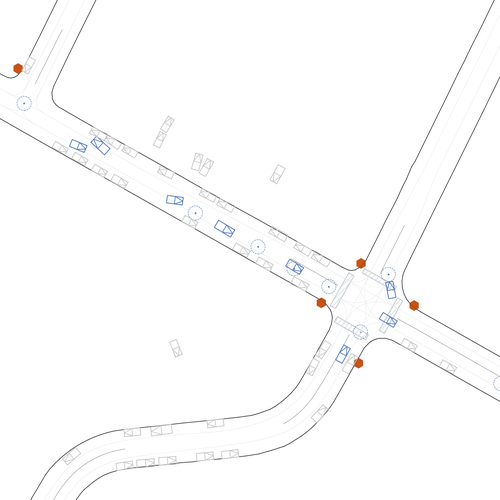
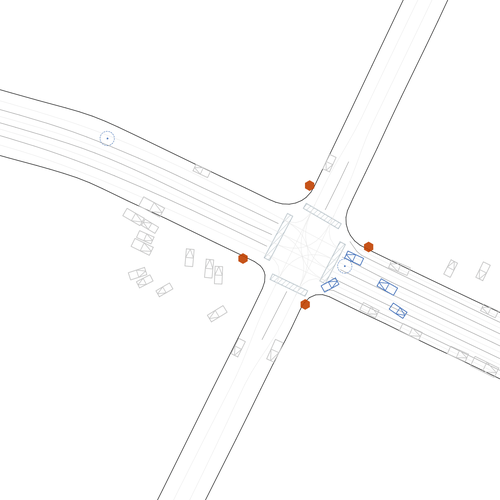

In [57]:
import mediapy
frames = get_frames(bc_policy)
mediapy.show_videos(frames, fps=5, width=500, height=500, columns=2, codec='gif')

In [ ]:
bc_policy(obs, deterministic=True)[0]

(tensor([[ 1.8115, -0.1570,  0.1100],
         [ 1.3708, -0.0873,  0.0798]], device='cuda:0', grad_fn=<AddBackward0>),
 None)